## Downloading dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Path to dataset files: /kaggle/input/human-face-emotions


In [2]:
import os
from pathlib import Path
import torch

data_dir = os.path.join(path, "Data")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
from sklearn.model_selection import train_test_split


train_image_paths = {}
test_image_paths = {}

for emotion in os.listdir(data_dir):
    emotion_dir = os.path.join(data_dir, emotion)
    if os.path.isdir(emotion_dir):
        image_files = [os.path.join(emotion_dir, f) for f in os.listdir(emotion_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
        train_image_paths[emotion] = train_files
        test_image_paths[emotion] = test_files

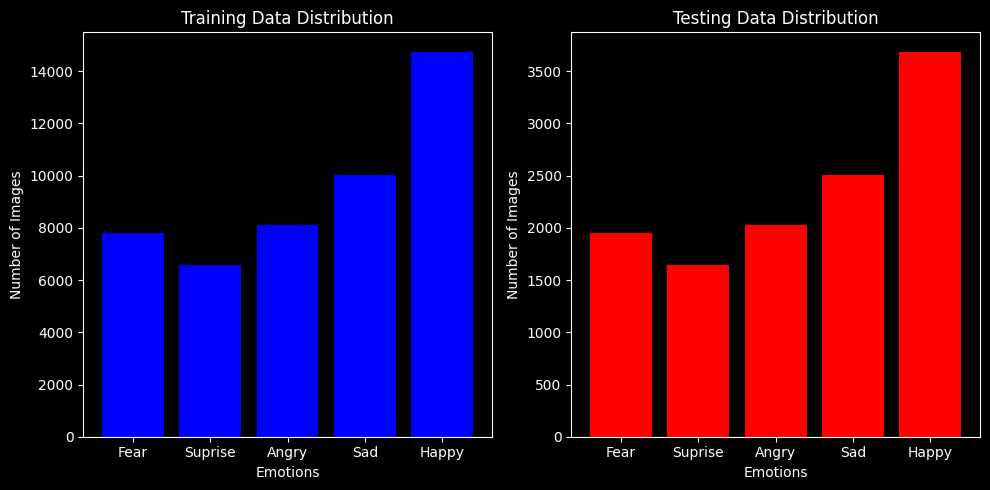

In [5]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# plot of train and test classes counts bar chart
train_counts = {emotion: len(paths) for emotion, paths in train_image_paths.items()}
test_counts = {emotion: len(paths) for emotion, paths in test_image_paths.items()}

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values(), color='blue')
plt.title('Training Data Distribution')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values(), color='red')
plt.title('Testing Data Distribution')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

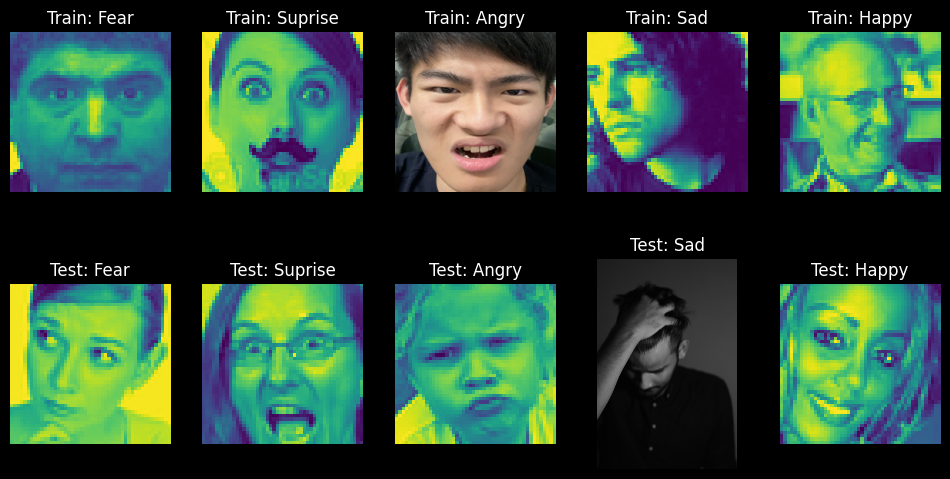

In [6]:
from PIL import Image

# plot 1 sample from  train and test for every emotion
plt.figure(figsize=(12, 6))
for i, emotion in enumerate(train_image_paths.keys()):
    plt.subplot(2, len(train_image_paths), i + 1)
    img = plt.imread(train_image_paths[emotion][0])
    plt.imshow(img)
    plt.title(f'Train: {emotion}')
    plt.axis('off')

    plt.subplot(2, len(test_image_paths), i + 1 + len(train_image_paths))
    img = Image.open(test_image_paths[emotion][0])
    plt.imshow(img)
    plt.title(f'Test: {emotion}')
    plt.axis('off')

In [7]:
IMG_WIDTH, IMG_HEIGHT = Image.open(train_image_paths['Angry'][1000]).size

IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
print("Image Size:", IMG_SIZE)

Image Size: (48, 48)


In [9]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device)),
])

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device)),
])

In [10]:
from itertools import chain

import torch
from torch.utils.data import Dataset, DataLoader


class FacialExpressionDataset(Dataset):
    def __init__(self, image_paths_dict, transform=None):
        self.image_paths_dict = image_paths_dict
        self.transform = transform
        self.image_paths = list(chain.from_iterable(image_paths_dict.values()))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, image

In [15]:
train_set = FacialExpressionDataset(train_image_paths, train_transform)
test_set = FacialExpressionDataset(test_image_paths, test_transform)

batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [20]:
from torch import nn, optim


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(IMG_WIDTH * IMG_HEIGHT * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, IMG_WIDTH * IMG_HEIGHT * 3),
            nn.Sigmoid(),
        )

        self.autoencoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        return self.autoencoder(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)


In [21]:
autoencoder = AutoEncoder()
autoencoder.to(device)

lr = 0.001
epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    autoencoder.train()
    running_train_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images.view(outputs.size()))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    autoencoder.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            outputs = autoencoder(images)
            loss = criterion(outputs, images.view(outputs.size()))
            running_test_loss += loss.item() * images.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f'Epoch [{epoch}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')


Epoch [1/10], Train Loss: 0.0364, Test Loss: 0.0295
Epoch [2/10], Train Loss: 0.0263, Test Loss: 0.0243
Epoch [3/10], Train Loss: 0.0226, Test Loss: 0.0207
Epoch [4/10], Train Loss: 0.0203, Test Loss: 0.0197
Epoch [5/10], Train Loss: 0.0189, Test Loss: 0.0175
Epoch [6/10], Train Loss: 0.0173, Test Loss: 0.0168
Epoch [7/10], Train Loss: 0.0165, Test Loss: 0.0162
Epoch [8/10], Train Loss: 0.0159, Test Loss: 0.0167
Epoch [9/10], Train Loss: 0.0153, Test Loss: 0.0152
Epoch [10/10], Train Loss: 0.0144, Test Loss: 0.0145


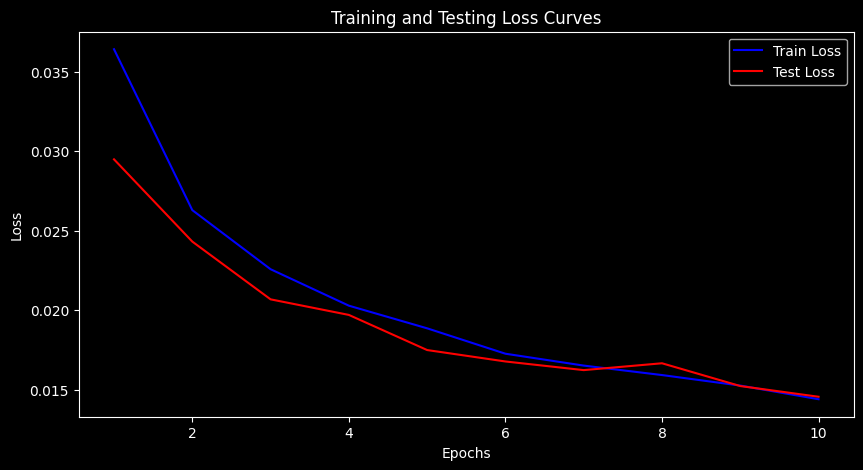

Final Train Loss: 0.0144
Final Test Loss: 0.0145


In [24]:
# plotting loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss Curves')
plt.show()


final_train_loss = train_losses[-1]
final_test_loss = test_losses[-1]
print(f'Final Train Loss: {final_train_loss:.4f}')
print(f'Final Test Loss: {final_test_loss:.4f}')

In [25]:
torch.save(autoencoder.state_dict(), 'dense_fc_autoencoder.pth')